# RNN Model Using Numpy

Ryan Roi Cayas \
2022-22085


In [ ]:
import torch
torch.manual_seed(42)

import random
random.seed(42)

## Load MNIST data

In [ ]:
import torch
import torchvision
from torchvision import transforms
import os

# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
if os.path.exists('./data/MNIST'):
  train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
  test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)
else:
  train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
  test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create the data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Train an RNN Model Using Torch

In [ ]:
import torch
import torch.nn as nn

# Build an RNN model to classsify MNIST images
class RNN(nn.Module):
    def __init__(self, input_size=28, hidden_size=256, num_layers=1, num_classes=10):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # input is a "sequence" of 28 features w/ length 28
        x = x.squeeze(1)
        y, _ = self.rnn(x) #, h0)
        # retrieve the last element of the sequence
        y = self.fc(y[:, -1, :])
        return y


x = torch.randn(64, 1, 28, 28)
model = RNN(num_layers=2)
print(model)
print(model(x).shape)

# print the number of parameters
num_params = sum(p.numel() for p in model.parameters())
# Use comma to print the number in a more readable format
print(f"Number of parameters: {num_params:,}")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from tqdm import tqdm

num_epochs = 10

model.train()
for epoch in tqdm(range(num_epochs)):
    total_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    avg_loss = total_loss / len(train_loader)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")


RNN(
  (rnn): RNN(28, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)
torch.Size([64, 10])
Number of parameters: 207,370


 10%|█         | 1/10 [01:26<12:59, 86.63s/it]

Epoch: 1, Loss: 0.5977


 20%|██        | 2/10 [02:44<10:50, 81.32s/it]

Epoch: 2, Loss: 0.2429


 30%|███       | 3/10 [03:59<09:11, 78.72s/it]

Epoch: 3, Loss: 0.1922


 40%|████      | 4/10 [05:16<07:46, 77.75s/it]

Epoch: 4, Loss: 0.1646


 50%|█████     | 5/10 [06:32<06:25, 77.11s/it]

Epoch: 5, Loss: 0.1528


 60%|██████    | 6/10 [07:45<05:03, 75.77s/it]

Epoch: 6, Loss: 0.1356


 70%|███████   | 7/10 [08:58<03:44, 74.86s/it]

Epoch: 7, Loss: 0.1304


 80%|████████  | 8/10 [10:11<02:28, 74.49s/it]

Epoch: 8, Loss: 0.1423


 90%|█████████ | 9/10 [11:25<01:14, 74.27s/it]

Epoch: 9, Loss: 0.1402


100%|██████████| 10/10 [12:39<00:00, 75.95s/it]

Epoch: 10, Loss: 0.1400


## Verify Test Accuracy of Torch RNN Model

In [ ]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy Using NN Module: {accuracy:.4f}")

Test Accuracy Using NN Module: 0.9532


## Get Torch Model Weights

In [ ]:
# Check RNN model weights
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

rnn.weight_ih_l0 torch.Size([256, 28])
rnn.weight_hh_l0 torch.Size([256, 256])
rnn.bias_ih_l0 torch.Size([256])
rnn.bias_hh_l0 torch.Size([256])
rnn.weight_ih_l1 torch.Size([256, 256])
rnn.weight_hh_l1 torch.Size([256, 256])
rnn.bias_ih_l1 torch.Size([256])
rnn.bias_hh_l1 torch.Size([256])
fc.weight torch.Size([10, 256])
fc.bias torch.Size([10])


In [ ]:
import numpy as np

# Create an empty dictionary to store the parameters
param_dict = {}

# Iterate over the model's named parameters
for name, param in model.named_parameters():
    # Convert the parameter to a NumPy array and store it in the dictionary
    param_dict[name] = param.detach().cpu().numpy()

## Building the pyRNN Model

In [ ]:
import numpy as np

class PyRNN():
    def __init__(self, input_size=28, hidden_size=256, num_layers=1, num_classes=10, param_dict=None):
        # param_dict is a dict containing the model weights:
          # e.g. param_dict['rnn.weight_ih_l0']

        self.num_layers = num_layers

        # Initialize weights randomly if param_dict is not provided (OPTIONAL)
        if param_dict is None:
            # Initialization for W_ih and W_hh
            self.W_ih = [np.random.uniform(low=-np.sqrt(1 / hidden_size),
                                          high=np.sqrt(1 / hidden_size),
                                          size=(hidden_size, input_size if i == 0 else hidden_size))
                          for i in range(num_layers)]
            self.W_hh = [np.random.uniform(low=-np.sqrt(1 / hidden_size),
                                          high=np.sqrt(1 / hidden_size),
                                          size=(hidden_size, hidden_size))
                          for i in range(num_layers)]
            self.b_ih = [np.random.uniform(low=-np.sqrt(1 / hidden_size),
                                          high=np.sqrt(1 / hidden_size),
                                          size=(hidden_size,))
                          for i in range(num_layers)]
            self.b_hh = [np.random.uniform(low=-np.sqrt(1 / hidden_size),
                                          high=np.sqrt(1 / hidden_size),
                                          size=(hidden_size,))
                          for i in range(num_layers)]


            # Weights for fully connected layer
            self.W_fc = np.random.uniform(low=-np.sqrt(6 / (hidden_size + num_classes)),
                                        high=np.sqrt(6 / (hidden_size + num_classes)),
                                        size=(num_classes, hidden_size))
            self.b_fc = np.zeros(num_classes)
        else:
            # Load weights from param_dict
            self.W_ih = [param_dict[f'rnn.weight_ih_l{i}'] for i in range(num_layers)]
            self.W_hh = [param_dict[f'rnn.weight_hh_l{i}'] for i in range(num_layers)]
            self.b_ih = [param_dict[f'rnn.bias_ih_l{i}'] for i in range(num_layers)]
            self.b_hh = [param_dict[f'rnn.bias_hh_l{i}'] for i in range(num_layers)]
            self.W_fc = param_dict['fc.weight']
            self.b_fc = param_dict['fc.bias']



        def fc_linear(x, W, b):
            return np.dot(x, W.T) + b

        def RNN_forward(x, W_ih, W_hh, b_ih, b_hh, h0 = None):
            # Initialize the hidden state
            if h0 is None:
              h = np.zeros((x.shape[0], hidden_size))
            else:
              h = h0

            # Initialize the output
            y = np.zeros((x.shape[0], x.shape[1], hidden_size))

            for t in range(x.shape[1]):
                # print variable shapes
                # print("x[:, t, :] shape:", x[:, t, :].shape)
                # print("W_ih shape:", W_ih.shape)
                # print("W_hh shape:", W_hh.shape)
                # print("b_ih shape:", b_ih.shape)
                # print("b_hh shape:", b_ih.shape)

                # Compute the hidden state
                h = np.tanh(np.dot(x[:, t, :], W_ih.T) + np.dot(h, W_hh.T) + b_ih + b_hh)

                # Compute the output
                y[:, t, :] = h

            return y, h

        self.RNN_forward = RNN_forward
        self.fc_linear = fc_linear

    def forward(self, x):
        # input is a "sequence" of 28 features w/ length 28
        x = np.squeeze(x, axis=1)

        # Loop through layers
        for i in range(self.num_layers):
            # Apply RNN logic for current layer
            y, _ = self.RNN_forward(
                x if i == 0 else y,  # Input is x for first layer, previous layer's output otherwise
                self.W_ih[i], self.W_hh[i], self.b_ih[i], self.b_hh[i]
            )

        # Use output of last layer for classification
        y = self.fc_linear(y[:, -1, :], self.W_fc, self.b_fc)
        return y

x = torch.randn(64, 1, 28, 28)
model_pyRNN = PyRNN(num_layers=2, param_dict=param_dict)
print(model_pyRNN.forward(x).shape)

(64, 10)


## Evaluate the pyRNN model

In [ ]:
correct = 0
total = 0

for images, labels in test_loader:
    # Forward pass
    outputs = model_pyRNN.forward(images)
    predicted = np.argmax(outputs, axis=1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy of the PyRNN Model: {accuracy:.4f}")

Test Accuracy of the PyRNN Model: 0.9532


## Visualize random test sample predictions

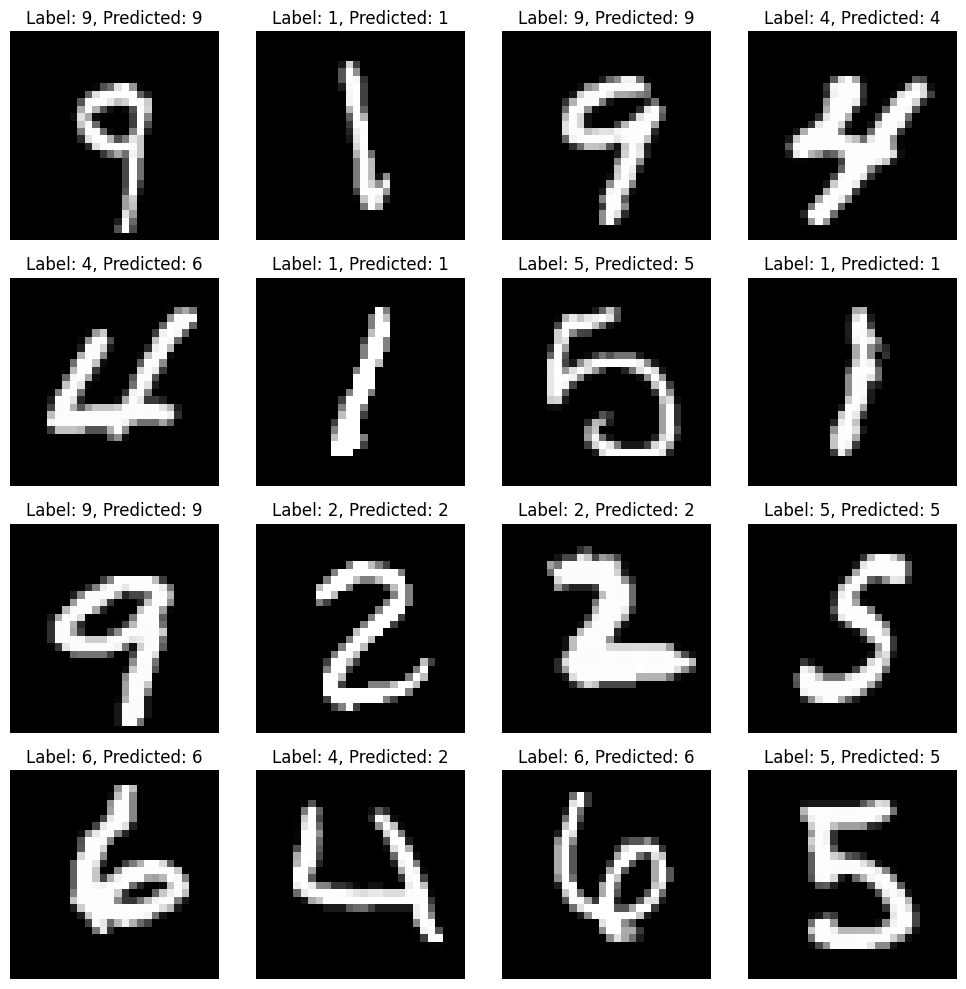

In [ ]:
import matplotlib.pyplot as plt

# Get 16 random indices
indices = np.random.choice(len(test_dataset), size=16, replace=False)

# Get the corresponding images and labels
images = np.array([test_dataset[i][0] for i in indices])
labels = [test_dataset[i][1] for i in indices]

# Get predicted label of all images
outputs = model_pyRNN.forward(images)
predictions = np.argmax(outputs, axis=1)

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Iterate over the subplots and display the images with labels
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[i]}, Predicted: {predictions[i]}")
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# The accuracy of the RNN implementation using Python Numpy is close/equal to the accuracy of the RNN algorithm using the torch.nn module.

## Accuracy using Python Numpy: 95.32 %
## Accuracy using NN Module: 95.32 %